<a href="https://colab.research.google.com/github/mrdbourke/m1-machine-learning-test/blob/main/01_food101_effnet_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food101 EfficientNetB0 Feature Extraction Benchmark

The following notebook tests the speed at which a given device can perform training iterations on the Food101 dataset (~100,000 total images) using [EfficientNetB0](https://arxiv.org/abs/1905.11946) as a base model.

It's designed to be a simple test to compare Apple's M1 (normal, Pro, Max) to each other and other sources of compute.

| Model | Dataset | Train Size | Test Size |
| ----- | ----- | ----- | ----- |
| [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) (pretrained on ImageNet) | Food 101 ([from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/food101)) | ~75,000 images | ~25,000 images|

## Resources
* Code on GitHub: https://github.com/mrdbourke/m1-machine-learning-test
* Code in this notebook adapted from: https://dev.mrdbourke.com/tensorflow-deep-learning/07_food_vision_milestone_project_1/ 

## Check for GPU

If you're using Google Colab, you'll need to activate a GPU:
1. Go to "Runtime"
2. Go to "Change Runtime Type"
3. Select "GPU"
4. Click "Save" (this will restart the runtime)

If you're using a Mac with an M1 chip, the GPU should already be selected if you've installed TensorFlow correctly.

In [1]:
# This will error if not using a Nvidia GPU (only works on Colab)
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
# Check for GPU using TensorFlow
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Setup hyperparameters

Change these to suit your needs.

The main one will be the device you're running code on.

E.g. `DEVICE = "Google Colab (K80 GPU)"` if using Google Colab.

In [3]:
# Setup hyperparameters
BATCH_SIZE = 32 # good for your health: https://twitter.com/ylecun/status/989610208497360896
EPOCHS = 5 # only run for a short period of time... we don't have all day
DATASET_NAME = "food101" # change this to try other image datasets from TensorFlow Datasets
DEVICE = "Apple M1 Max" # Note: Change this depending on where you're running code

## Get helper functions and import dependencies

The function below downloads the helper functions if necessary (if running this notebook in Google Colab, it's easier to download a single file than clone the whole repo).

In [4]:
# Get helper functions
import os
import requests

if not os.path.exists("helper_functions.py"):
  print("Downloading helper functions...")
  r = requests.get("https://raw.githubusercontent.com/mrdbourke/m1-machine-learning-test/main/helper_functions.py")
  print("Writing helper functions to file...")
  open("helper_functions.py", "wb").write(r.content)
else:
  print("Helper functions already downloaded, skipping redownload.")

Helper functions already downloaded, skipping redownload.


In [5]:
# Check TensorFlow version
import tensorflow as tf
print(tf.__version__) # should be 2.5.0+

# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# Get data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from timeit import default_timer as timer 
from helper_functions import print_train_time

2.6.0


## Download Data

We'll download the data from the Food101 dataset [stored in TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/food101). This dataset contains ~100,000 images and should be a good test to see how the machines go with a larger dataset.

> **Note:** Downloading the dataset (running the cell below) will download ~4.5GB of images to your local machine (or to Google Colab). Depending on your internet, it could take 5-20 minutes.



In [6]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name=DATASET_NAME, # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

2021-11-15 10:44:30.003665: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling food101-train.tfrecord...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling food101-validation.tfrecord...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /Users/daniel/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Metal device set to: Apple M1 Max


2021-11-15 11:00:44.690730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-15 11:00:44.690850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Check out dataset

Let's check a few things with the data to make sure it's okay to model. 

In [7]:
# Check number of samples
len(train_data), len(test_data)

(75750, 25250)

In [8]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10], len(class_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese
        


2021-11-15 11:02:28.619194: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-15 11:02:28.619975: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


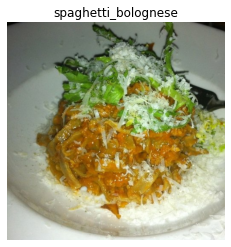

In [9]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)
  plt.imshow(image)
  plt.title(class_names[label.numpy()])
  plt.axis(False)

## Prepare data

The data looks good. But before we model it, we're going to prepare it to run as fast as possible using [TensorFlow data loading best practices](https://www.tensorflow.org/guide/data_performance).

As EfficientNetB0 takes images of size `(224, 224, 3)`, we'll resize all the images to that size.

In [10]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [11]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Setup model

We'll setup the model to use EfficientNetB0 pretrained on ImageNet as the base model. But we'll replace the top layers to be more suited to our Food101 problem (101 output neurons instead of the standard 1000 output neurons).

Also we'll run the model setup code before fitting the model so the model downloads to file separate from training (this will ensure the model downloading time won't add to the training time measure).

In [12]:
# Set random seed
tf.random.set_seed(42)

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x) # want one output neuron per class 
model = tf.keras.Model(inputs, outputs, name="EfficientNetB0_feature_extract")

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 3s 0us/step


## Fit the model

Let's fit the model and track it's performance.

We're not so much concerned of the accuracy as much as the time per epoch.

In [13]:
# Start timer
start_time = timer()

# Fit the model
history = model.fit(train_data, 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

# End timer
end_time = timer()

# Print results
train_time = print_train_time(start=start_time,
                              end=end_time,
                              device=DEVICE)

Epoch 1/5


2021-11-15 11:02:42.643796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 1.8234 - accuracy: 0.5564

2021-11-15 11:05:08.531784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 195s 80ms/step - loss: 1.8234 - accuracy: 0.5564 - val_loss: 1.2293 - val_accuracy: 0.6769
Epoch 2/5
2368/2368 [==============================] - 194s 82ms/step - loss: 1.2948 - accuracy: 0.6665 - val_loss: 1.1288 - val_accuracy: 0.6982
Epoch 3/5
2368/2368 [==============================] - 189s 80ms/step - loss: 1.1449 - accuracy: 0.7025 - val_loss: 1.0820 - val_accuracy: 0.7099
Epoch 4/5
2368/2368 [==============================] - 190s 80ms/step - loss: 1.0472 - accuracy: 0.7264 - val_loss: 1.0703 - val_accuracy: 0.7093
Epoch 5/5
2368/2368 [==============================] - 190s 80ms/step - loss: 0.9730 - accuracy: 0.7451 - val_loss: 1.0705 - val_accuracy: 0.7102

Train time on Apple M1 Max: 958.951 seconds


## Track results and save to file

In [14]:
results = {
    "device": DEVICE,
    "dataset_name": DATASET_NAME,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "num_train_samples": len(train_data)*BATCH_SIZE,
    "num_test_samples": len(test_data)*BATCH_SIZE,
    "total_train_time": round(train_time, 3),
    "time_per_epoch": round(train_time/EPOCHS, 3),
    "model": model.name
    }
results_df = pd.DataFrame(results, index=[0])
results_df

,device,dataset_name,epochs,batch_size,num_train_samples,num_test_samples,total_train_time,time_per_epoch,model
0,Apple M1 Max,food101,5,32,75776,25280,958.951,191.79,EfficientNetB0_feature_extract


In [15]:
# Write CSV to file
if not os.path.exists("results/"):
  os.makedirs("results/")

results_df.to_csv(f"results/{DEVICE}_{DATASET_NAME}.csv")

## Extras

Make sure to delete the extra downloaded files (the Food101 dataset) if you do not want to keep them on your machine.

In [16]:
# Change this to suit your path
import shutil
try:
    shutil.rmtree("/Users/daniel/tensorflow_datasets/food101/")
except OSError as e:
    print(f"Error: {e.filename} - {e.strerror}")